In [242]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting
import nilearn
from tree_features import connectome_average, matrix_fusion, tree_connectivity, tree_modules, level_dictionary, level_from_tree
from tree_features import T_from_level, adj_matrices_from_level, brain_maps_network_measure, threshold_based_similarity_external, density_threshold
from tree_features import tree_dictionary, get_module_vol, cross_modularity, add_gamma_to_lvl_dict, threshold_based_similarity, modularity, network_from_level
from tree_features import measure_betweenness, measure_strength, measure_clustering_coef, measure_pathlength, get_atlas_rois_from_mask
from io_functions import load_data
import os
import json
import glob
import inspect
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns
import networkx as nx

In [3]:
project_path = "/home/antoniojm/Documents/projects/BHA_5G/lemon"
sc_group = load_data(os.path.join(project_path, "sc"))
fc_group = load_data(os.path.join(project_path, "fc"))
fcm, scm = connectome_average(fc_group, sc_group)

In [113]:
fcm, scm = connectome_average(fc_group, sc_group)
print(fcm.shape)
print(scm.shape)

(2128, 2128)
(2128, 2128)


In [115]:
density = np.where(scm.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm.flatten()))
fcm_thr = density_threshold(fcm, density)
zero_rows = np.where(~fcm_thr.any(axis=1))[0][0]

#remove the element zero_rows from fcm and scm
fcm_thr_nonzero = np.delete(fcm_thr, zero_rows, axis=0)
fcm_thr_nonzero = np.delete(fcm_thr_nonzero, zero_rows, axis=1)
scm_nonzero = np.delete(scm, zero_rows, axis=0)
scm_nonzero = np.delete(scm_nonzero, zero_rows, axis=1)
print(fcm_thr_nonzero.shape)
print(scm_nonzero.shape)

(2127, 2127)
(2127, 2127)


In [118]:
tree_folder = "tree_network_measures"
tree_min = 3
tree_max = 100
#get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_thr_nonzero, scm_nonzero)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    json.dump(t_dict, open(os.path.join(project_path, "df_connectomes", "tree_network_measures", "tree_equaldensity_g_" + str(round(g, 2)) + ".json"), "w"))


In [226]:
lvlmin = 49
lvlmax = 99
crossmod_gammas = np.empty((lvlmax - lvlmin, 1))
mod_sc_gammas = np.empty((lvlmax - lvlmin, 1))
mod_fc_gammas = np.empty((lvlmax - lvlmin, 1))
sim_gammas = np.empty((lvlmax - lvlmin, 1))
thrs_tree = {}
for g in np.arange(0, 1.1, 0.1):
    tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
        "tree_equaldensity_g_" + str(round(g, 2)) + ".json")).read())
    crossmod = []
    mod_sc = []
    mod_fc = []
    sim_lvl = []
    for l in range(lvlmin,lvlmax):
        level, labels = level_from_tree(tree, l)
        T = T_from_level(level)
        sim, thrs = threshold_based_similarity(fcm_thr_nonzero, scm_nonzero, level, labels)
        thrs_tree.update(add_gamma_to_lvl_dict(thrs, g))
        mod_sc_lvl = modularity(scm_nonzero, T)
        mod_fc_lvl = modularity(fcm_thr_nonzero, T)
        mod_sc.append(mod_sc_lvl)
        mod_fc.append(mod_fc_lvl)
        sim_lvl.append(np.nanmean(sim))
        c = pow((np.nanmean(sim) * mod_sc_lvl * mod_fc_lvl), (1 / 3))
        crossmod.append(c)
    crossmod_gammas = np.hstack((crossmod_gammas, np.array(crossmod).reshape(-1,1)))
    mod_sc_gammas = np.hstack((mod_sc_gammas, np.array(mod_sc).reshape(-1,1)))
    mod_fc_gammas = np.hstack((mod_fc_gammas, np.array(mod_fc).reshape(-1,1)))
    sim_gammas = np.hstack((sim_gammas, np.array(sim_lvl).reshape(-1,1)))

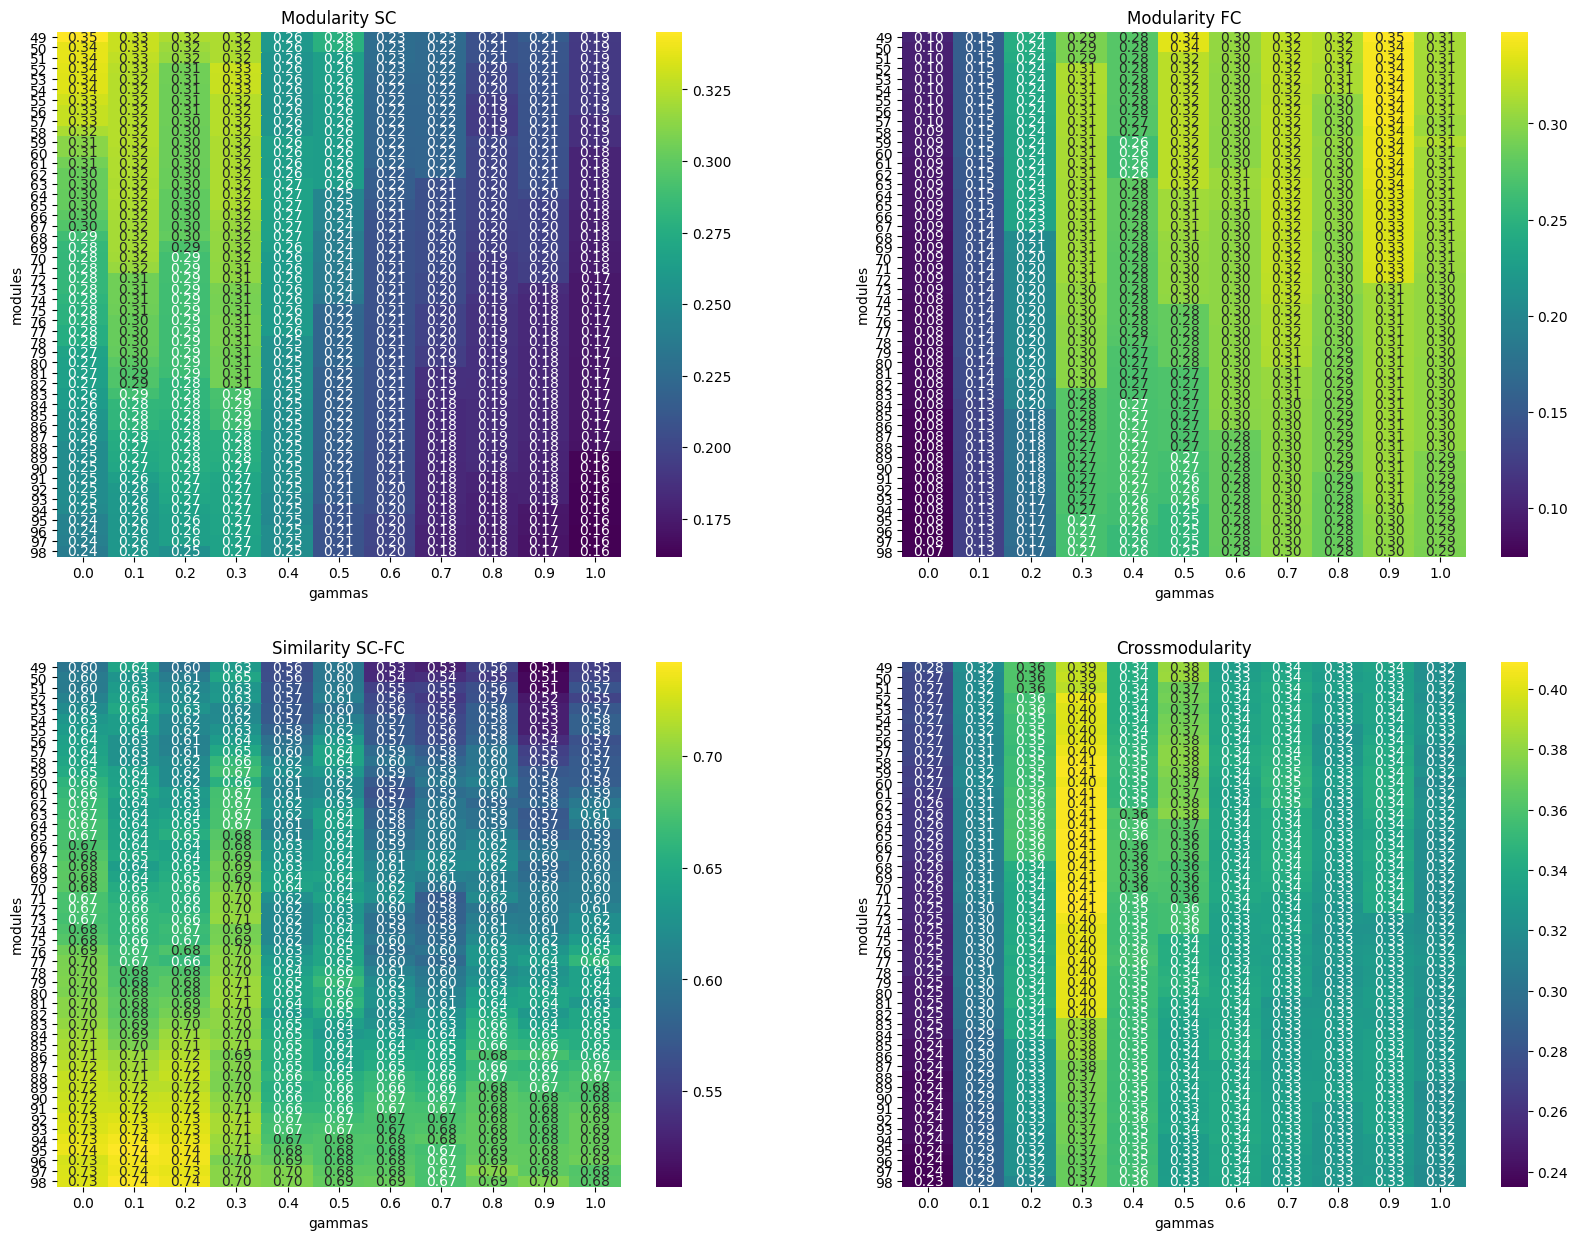

In [227]:
plot, axes = plt.subplots(2, 2, figsize=(20, 15))

h1 = sns.heatmap(mod_sc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[0,0])
_ = h1.set(xlabel='gammas', ylabel='modules')
_ = h1.set_title("Modularity SC")

h2 = sns.heatmap(mod_fc_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[0,1])
_ = h2.set(xlabel='gammas', ylabel='modules')
_ = h2.set_title("Modularity FC")

h3 = sns.heatmap(sim_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[1,0])
_ = h3.set(xlabel='gammas', ylabel='modules')
_ = h3.set_title("Similarity SC-FC")

h4 = sns.heatmap(crossmod_gammas[:,1:], cmap='viridis', 
    xticklabels=np.around(np.arange(0, 1.1, 0.1),2), yticklabels=np.arange(lvlmin, lvlmax), 
    annot=True, fmt=".2f", ax=axes[1,1])
_ = h4.set(xlabel='gammas', ylabel='modules')
_ = h4.set_title("Crossmodularity")

In [237]:
key_pattern = "gamma_" + str(round(gammas_vec[y][0],2)) + "_lvl_" + str(levels_vec[x][0]) + "_mod_"
key_pattern

'gamma_0.3_lvl_72_mod_'

'gamma_0.3_lvl_72_mod_'

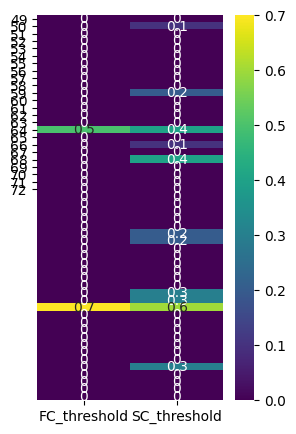

In [238]:
cmod = crossmod_gammas[:,1:]
x,y = np.where(cmod == np.nanmax(cmod))
gammas_vec = np.arange(0, 1.1, 0.1)
levels_vec = np.arange(lvlmin, lvlmax)
key_pattern = "gamma_" + str(round(gammas_vec[y][0],2)) + "_lvl_" + str(levels_vec[x][0]) + "_mod_"
thresholds = [value for key,value in thrs_tree.items() if key.startswith(key_pattern)]
fig, ax = plt.subplots(figsize=(3,5))
sns.heatmap(thresholds, cmap='viridis', annot=True, ax = ax,
    yticklabels=np.arange(lvlmin, levels_vec[x]+1),
    xticklabels = np.array(['FC_threshold', 'SC_threshold']))
key_pattern

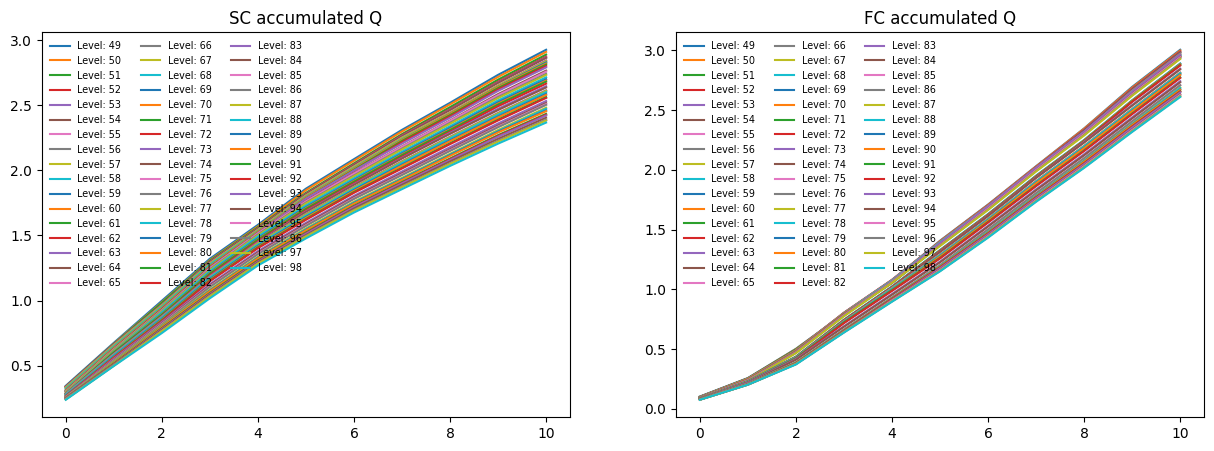

In [241]:
plot, axes = plt.subplots(1, 2, figsize=(15,5))

for nmod in range(len(mod_sc_gammas)):
    axes[0].plot(np.cumsum(mod_sc_gammas[nmod,1:]), label="Level: " + str(nmod+lvlmin))
    axes[1].plot(np.cumsum(mod_fc_gammas[nmod,1:]), label="Level: " + str(nmod+lvlmin))
axes[0].legend(frameon=False, loc='upper left', ncol=3, fontsize='x-small')
axes[0].title.set_text('SC accumulated Q')
axes[1].legend(frameon=False, loc='upper left', ncol=3, fontsize='x-small')
axes[1].title.set_text('FC accumulated Q')

In [240]:
from nilearn.plotting import plot_prob_atlas
tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
        "tree_equaldensity_g_0.3.json")).read())
lvl = 72
level, labels = level_from_tree(tree, lvl)
atlas_name = "craddock_2128_2mm.nii.gz"
atlas = nib.load(os.path.join(project_path, atlas_name))
atlas_vol = atlas.get_fdata()
atlas_nonzero = atlas_vol
atlas_nonzero[atlas_vol == (zero_rows+1)] = 0
atlas_nonzero[atlas_vol == atlas_vol.max()] = 0

for i in range(zero_rows+2, int(atlas_vol.max())+1):
    atlas_nonzero[atlas_vol == i] = i-1

atlas_moduled = np.zeros((atlas_nonzero.shape[0],atlas_nonzero.shape[1],atlas_nonzero.shape[2]))
for idx,rois in enumerate(level):
    mod = get_module_vol(nib.Nifti1Image(atlas_nonzero, affine=atlas.affine), rois, idx+1)
    atlas_moduled = atlas_moduled + mod

img = nib.Nifti1Image(atlas_moduled, affine=atlas.affine)
nib.save(img, os.path.join(project_path, "df_connectomes", "tree_network_measures", "atlas_moduled_lvl_" + str(lvl) + ".nii.gz"))


(2127, 2127)


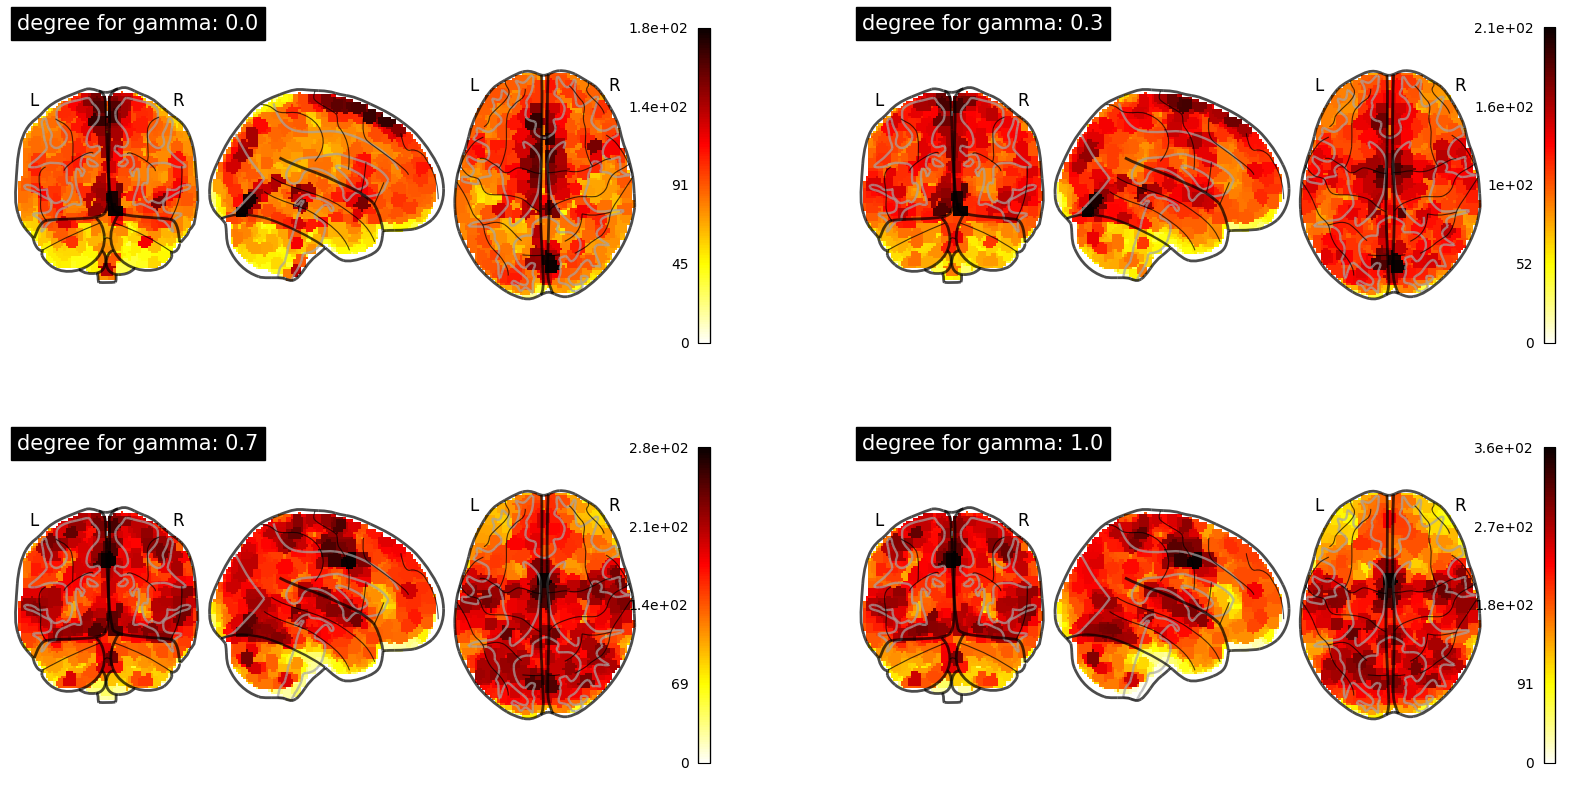

In [224]:
fig = plt.figure()
print(scm_nonzero.shape)
gammas_vec = [0.0, 0.3, 0.7, 1.0]    
for idx,g in enumerate(gammas_vec):
    ax = fig.add_subplot(2, 2, idx+1)
    cc = abs(((g * abs(fcm_thr_nonzero)) + ((1 - g) * scm_nonzero)))
    strength_fullmat = cc.sum(axis=0, dtype=float)
    deg_img = np.zeros(atlas_nonzero.shape)
    for roi in range(1,int(atlas_nonzero.max())+1):
        deg_img[atlas_nonzero == roi] = strength_fullmat[roi-1]
    
    plotting.plot_glass_brain(nib.Nifti1Image(deg_img, affine=atlas.affine), 
        colorbar=True, title="degree for gamma: " + str(g), axes=ax)

<AxesSubplot:xlabel='area', ylabel='strength'>

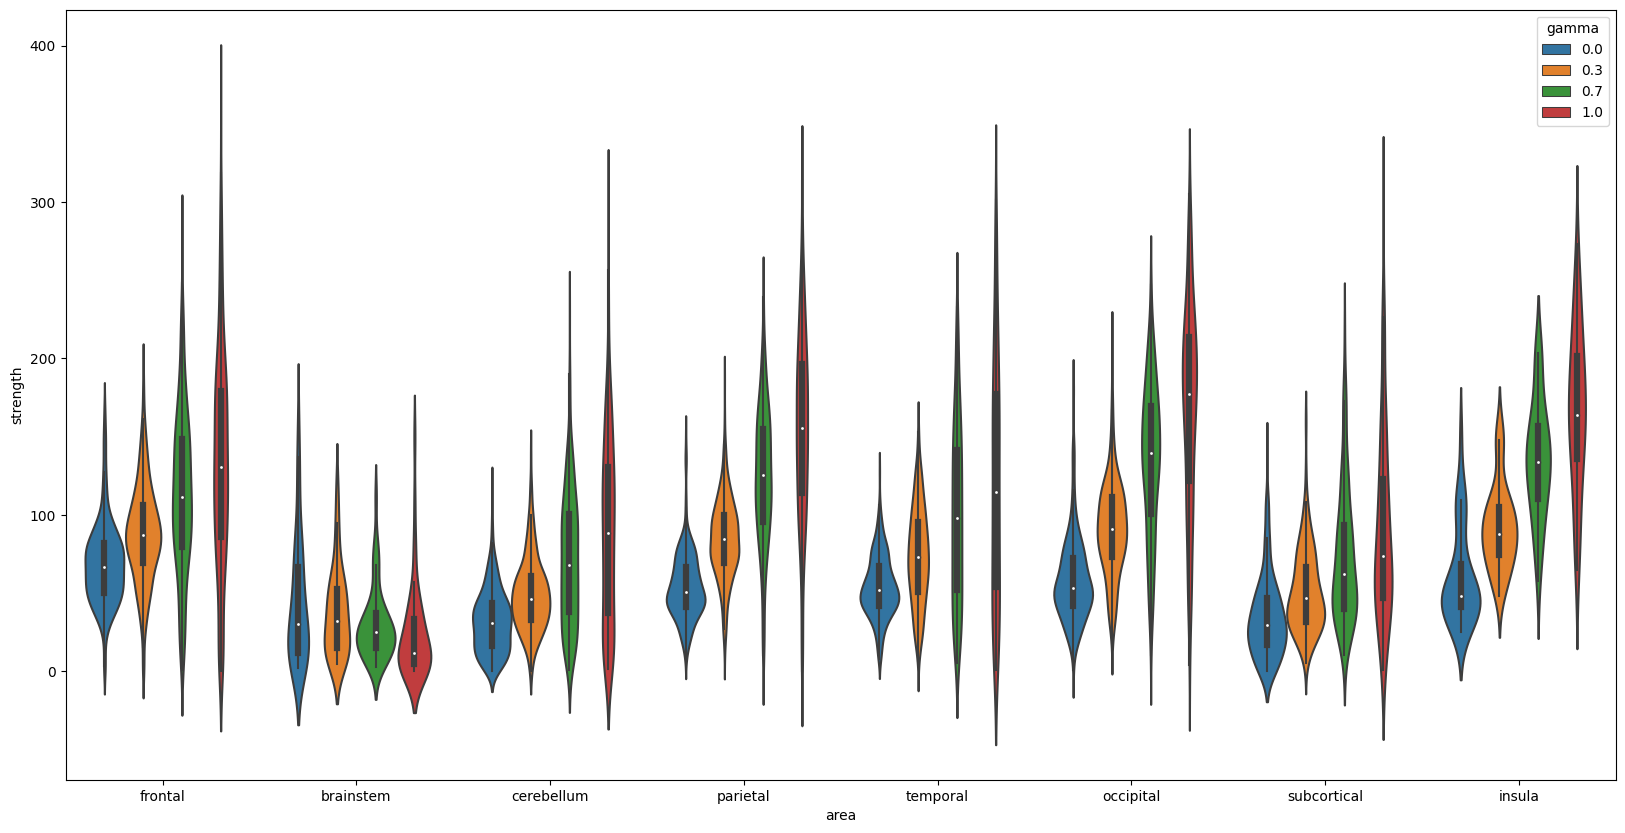

In [225]:
frontal_mask = nib.load('../brain_templates/lobule_masks/Frontal_mask.nii.gz')
bstem_mask = nib.load('../brain_templates/lobule_masks/Brain_stem_mask.nii.gz')
cerebellum_mask = nib.load('../brain_templates/lobule_masks/Cerebellum_mask.nii.gz')
insula_mask = nib.load('../brain_templates/lobule_masks/Insula_mask.nii.gz')
parietal_mask = nib.load('../brain_templates/lobule_masks/Parietal_mask.nii.gz')
temporal_mask = nib.load('../brain_templates/lobule_masks/Temporal_mask.nii.gz')
occipital_mask = nib.load('../brain_templates/lobule_masks/Occipital_mask.nii.gz')
subcortical_mask = nib.load('../brain_templates/lobule_masks/Subcortical_mask.nii.gz')

frois = get_atlas_rois_from_mask(frontal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
bstem = get_atlas_rois_from_mask(bstem_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
cerebellum = get_atlas_rois_from_mask(cerebellum_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
insula = get_atlas_rois_from_mask(insula_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
parietal = get_atlas_rois_from_mask(parietal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
temporal = get_atlas_rois_from_mask(temporal_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
occipital = get_atlas_rois_from_mask(occipital_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))
subcortical = get_atlas_rois_from_mask(subcortical_mask,nib.Nifti1Image(atlas_nonzero, affine=atlas.affine))

fig = plt.figure()
gammas_vec = [0.0, 0.3, 0.7, 1.0]

strength_vals = []
area_name = []
gamma_val = []

for idx,g in enumerate(gammas_vec):
    cc = abs(((g * abs(fcm_thr_nonzero)) + ((1 - g) * scm_nonzero)))
    strength_fullmat = cc.sum(axis=0, dtype=float)

    for roi in frois:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("frontal")
        gamma_val.append(g)

    for roi in bstem:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("brainstem")
        gamma_val.append(g)

    for roi in cerebellum:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("cerebellum")
        gamma_val.append(g)

    for roi in parietal:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("parietal")
        gamma_val.append(g)

    for roi in temporal:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("temporal")
        gamma_val.append(g)

    for roi in occipital:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("occipital")
        gamma_val.append(g)

    for roi in subcortical:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("subcortical")
        gamma_val.append(g)

    for roi in insula:
        strength_vals.append(strength_fullmat[int(roi)-1])
        area_name.append("insula")
        gamma_val.append(g)

df = pd.DataFrame({'strength': strength_vals, 'area': area_name, 'gamma': gamma_val})
sns.violinplot(x="area", y="strength", hue="gamma", data=df)

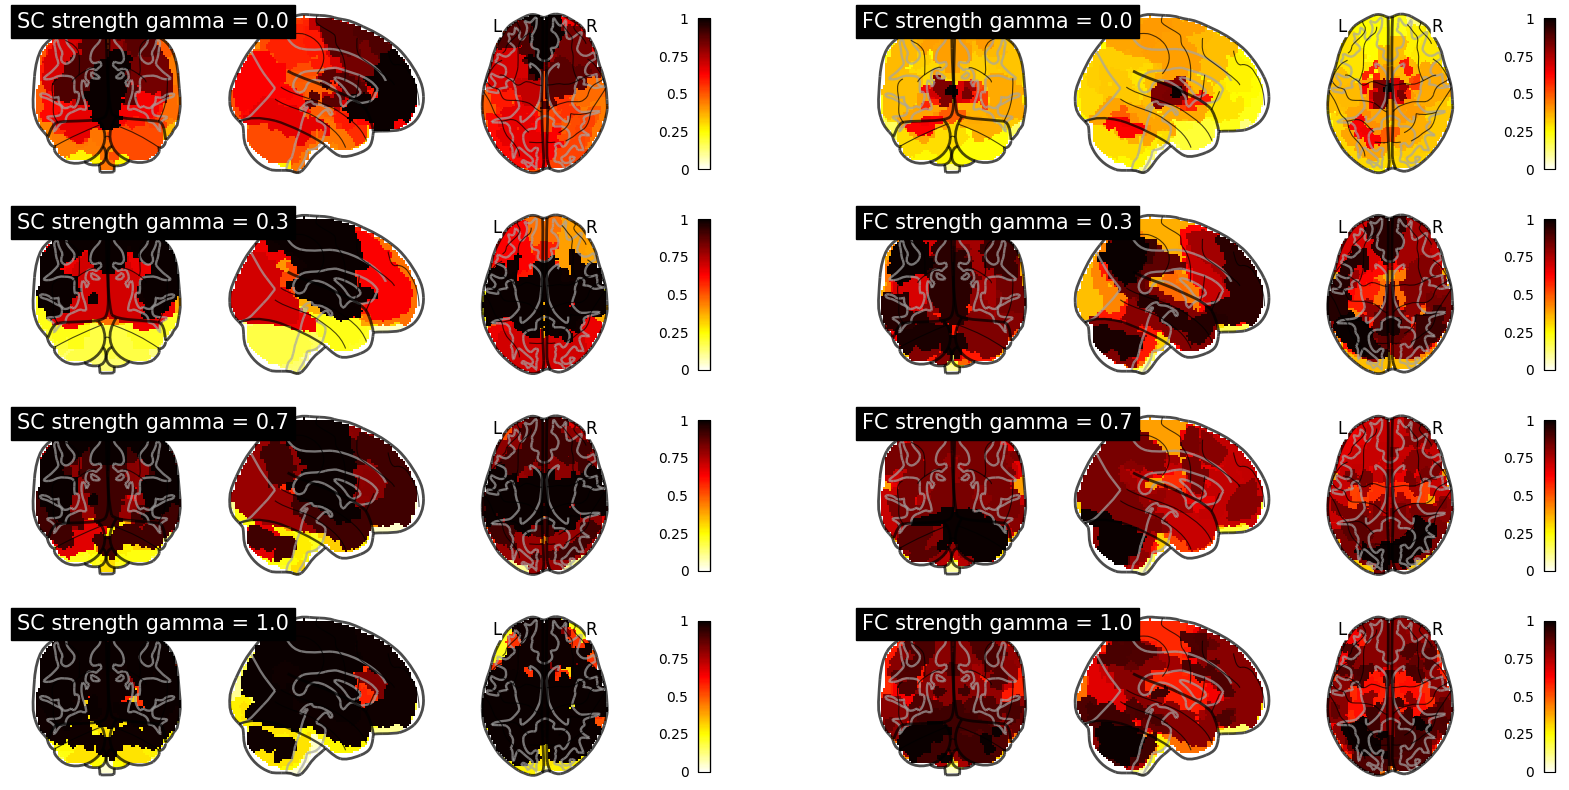

In [244]:
fig = plt.figure()
gammas_vec = [0.0, 0.3, 0.7, 1.0]
ind_subplot = 0    
for g in gammas_vec:
    ax1 = fig.add_subplot(4, 2, ind_subplot+1)
    ax2 = fig.add_subplot(4, 2, ind_subplot+2)
    ind_subplot += 2
    tree = json.loads(open(os.path.join(project_path, "df_connectomes", "tree_network_measures",
    "tree_equaldensity_g_" + str(g) + ".json")).read())
    
    measure_type = "strength"
    sc_meas_map, fc_meas_map = brain_maps_network_measure(tree, scm_nonzero, fcm_thr_nonzero, nib.Nifti1Image(atlas_nonzero, affine=atlas.affine),
                                                           range(20, 100), measure=measure_type)

    netw_img_sc = nib.Nifti1Image(sc_meas_map, affine=atlas.affine)
    netw_img_fc = nib.Nifti1Image(fc_meas_map, affine=atlas.affine)
    figure = plotting.plot_glass_brain(netw_img_sc, title="SC " + measure_type + " gamma = " + str(g), colorbar=True, axes=ax1)
    figure = plotting.plot_glass_brain(netw_img_fc, title="FC " + measure_type + " gamma = " + str(g), colorbar=True, axes=ax2)